##### Combine datasets 'llm answers', galucinations, etc and visualize them

2024-11-04 20:55:14,935 - INFO - Max length across specified columns: 4096
2024-11-04 20:55:14,935 - INFO - ['NQ TRUE answers llama3.1', 'correct_answers_llama3.1', 'factual_inaccuracy_llama3.1']
2024-11-04 20:55:14,935 - INFO - Padding applied. Reduced embeddings shape: (20, 3)


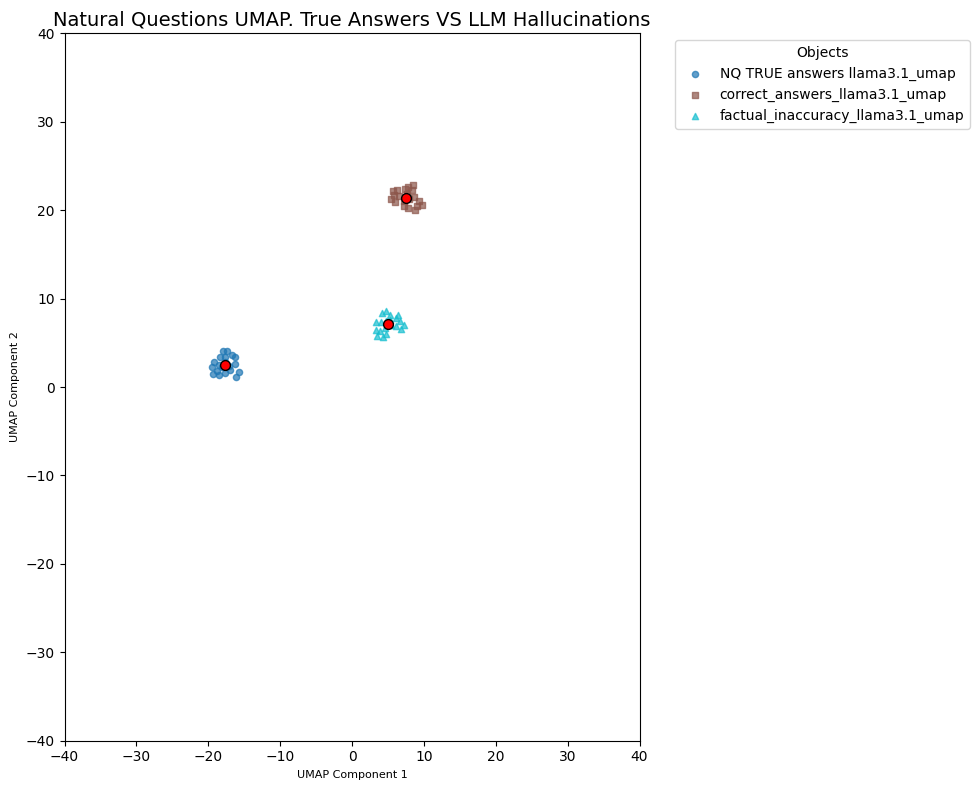

In [6]:
from src.services.similarity_service import find_centroids
from src.services.embedding_visualizer_service import EmbeddingVisualizer
import pandas as pd     

# Read LLM responses datasets 
true_answers = pd.read_csv('./data/llm_responses/NQ-llm-true-answers_llama3.1.csv')
correct_answers = pd.read_csv('./data/llm_responses/NQ-llm-correct_answers_llama3.1.csv')
factual_inaccuracy = pd.read_csv('./data/llm_responses/NQ-llm-factual_inaccuracy_llama3.1.csv')
#needle_in_haystack = pd.read_csv('./data/llm_responses/NQ-llm-needle_in_haystack_llama3.1.csv')

# Rename columns and concatenate datasets, keeping only the required columns
df_combined = pd.concat([
    true_answers.rename(columns={'true_answer_embedding_llama3.1': 'NQ TRUE answers llama3.1'})[['NQ TRUE answers llama3.1']],
    correct_answers.rename(columns={'embedding_llama3.1': 'correct_answers_llama3.1'})[['correct_answers_llama3.1']],
    factual_inaccuracy.rename(columns={'embedding_llama3.1': 'factual_inaccuracy_llama3.1'})[['factual_inaccuracy_llama3.1']]
    #needle_in_haystack.rename(columns={'embedding_llama3.1': 'needle_in_haystack_llama3.1'})[['needle_in_haystack_llama3.1']]
], axis=1)

# Display the combined DataFrame
# print(df_combined)

vis = EmbeddingVisualizer(df=df_combined)
vis.convert_columns_to_float_arrays()
vis.process_embeddings_padding()
df_umap = vis.apply_umap(n_components=2, rand_state=56)
centroids_df = find_centroids(df_umap)
vis.plot_umap_2d(df=df_umap, 
                 centroids=centroids_df, 
                 title="Natural Questions UMAP. True Answers VS LLM Hallucinations", 
                 save_path='./results_imgs/umap_2d.png')

##### Create centroid matrix with different random states

In [ ]:
vis = EmbeddingVisualizer(df=df_combined)
vis.convert_columns_to_float_arrays()
vis.process_embeddings_padding()
df_umap = vis.apply_umap(n_components=3)
vis.plot_umap_3d(df=df_umap, title="Natural Questions UMAP. True Answers VS LLM Hallucinations", save_path='./results_imgs/umap_3d.png')

In [ ]:
vis = EmbeddingVisualizer(df=df_combined)
vis.convert_columns_to_float_arrays()
vis.process_embeddings_padding()
df_umap = vis.apply_umap(n_components=12)
vis.plot_umap_12d_4x3d(df=df_umap, title="Natural Questions UMAP. True Answers VS LLM Hallucinations", save_path='./results_imgs/umap_12d_4x3d.png')